# Differential expression validation
This notebook performs a differential expression (DE) analysis comparing PAO1 samples vs PA14 samples. We can compare our results with those published in the literature as an additional step to validate that our RNA-seq processing pipeline is reasonable.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from core_acc_modules import utils, paths
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Download data for validation
Data from [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) found ~ 2K DEGs between 2 strains where Quorum Sensing (QS) genes were DEGs. QS or cell-to-cell signaling controls expression of genes involved in virulence and biofilm formation. QS systems make use of a transcriptional activator protein that acts in concert with a small signaling molecule to stimulate expression of target genes.

In [2]:
# Download sra data files
! prefetch --option-file $paths.SRA_ACC_TEST


2020-08-07T16:32:35 prefetch.2.8.2: 1) 'SRR8486287' is found locally

2020-08-07T16:32:35 prefetch.2.8.2: 2) 'SRR8486288' is found locally

2020-08-07T16:32:36 prefetch.2.8.2: 3) 'SRR8486289' is found locally

2020-08-07T16:32:36 prefetch.2.8.2: 4) 'SRR8486290' is found locally


In [3]:
%%bash -s $paths.FASTQ_TEST_DIR $paths.SRA_DIR $paths.FASTQ_TEST_DIR/
mkdir -p $1
fastq-dump $2/SRR8486287.sra --outdir $3
fastq-dump $2/SRR8486288.sra --outdir $3
fastq-dump $2/SRR8486289.sra --outdir $3
fastq-dump $2/SRR8486290.sra --outdir $3

Read 87030083 spots for /home/alexandra/ncbi/public/sra/SRR8486287.sra
Written 87030083 spots for /home/alexandra/ncbi/public/sra/SRR8486287.sra
Read 82431216 spots for /home/alexandra/ncbi/public/sra/SRR8486288.sra
Written 82431216 spots for /home/alexandra/ncbi/public/sra/SRR8486288.sra
Read 85676644 spots for /home/alexandra/ncbi/public/sra/SRR8486289.sra
Written 85676644 spots for /home/alexandra/ncbi/public/sra/SRR8486289.sra
Read 95267613 spots for /home/alexandra/ncbi/public/sra/SRR8486290.sra
Written 95267613 spots for /home/alexandra/ncbi/public/sra/SRR8486290.sra


In [4]:
%%bash -s $paths.PAO1_QUANT_TEST $paths.FASTQ_TEST_DIR $paths.PAO1_INDEX
mkdir -p $1

for FILE_PATH in $2/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i $3 -l A \
            -r ${base_name}/${sample_name} \
            -p 8 --validateMappings -o $1/${sample_name}_quant
done

Processing sample SRR8486287.fastq
Processing sample SRR8486288.fastq
Processing sample SRR8486289.fastq
Processing sample SRR8486290.fastq


Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pao1_index }
### [ libType ] => { A }
### [ unmatedReads ] => { /home/alexandra/ncbi/public/fastq_test/SRR8486287.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pao1_test/SRR8486287.fastq_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pao1_test/SRR8486287.fastq_quant/logs
[2020-08-07 12:59:21.650] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-08-07 12:59:21.650] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-08-07 12:59:21.650] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since not explicitly specified, it is being set to 0.65
[2020-08-07 12:59:21.650] [jointLog] [inf

In [5]:
# Get raw read counts using PAO1 reference
# Read through all sample subdirectories in quant/
# Within each sample subdirectory, get quant.sf file
data_dir = paths.PAO1_QUANT_TEST

expression_data = pd.DataFrame(
        pd.read_csv(file, sep="\t", index_col=0)["NumReads"].
        rename(file.parent.name.split("_")[0])
    for file in data_dir.rglob("*/quant.sf")
)    

# Map gene ids to gene names
pao1_fasta_file = paths.PAO1_REF

seq_id_to_gene_id_pao1 = utils.dict_gene_num_to_ids(pao1_fasta_file)

expression_data.rename(mapper=seq_id_to_gene_id_pao1, axis="columns", inplace=True)

expression_data.head()

Name,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
SRR8486287.fastq,1955.0,1552.0,899.0,3043.0,263.0,128.0,839.0,1198.0,304.0,30.0,...,213.0,679.0,363.0,114.0,1118.0,4.0,262.0,1458.0,793.0,1257.0
SRR8486289.fastq,3210.0,2354.0,1041.0,5630.0,324.0,125.0,300.0,2252.0,729.0,61.0,...,363.0,1756.0,1144.0,298.0,2667.0,6.0,673.0,4574.0,1937.0,2688.0
SRR8486290.fastq,2873.0,2160.0,989.0,5805.0,293.0,109.0,387.0,1647.0,529.0,61.0,...,254.0,1481.0,941.0,221.0,1909.0,4.0,613.0,3559.0,1594.0,1759.0
SRR8486288.fastq,2129.0,1188.0,1047.0,2349.0,232.0,155.0,819.0,754.0,283.0,41.0,...,280.0,452.0,278.0,73.0,1075.0,12.0,239.0,1098.0,569.0,932.0


In [6]:
# Format sample ids
# There was probably a way to get around doing this step in bash but to get a quick validation I have done this
new_index = [name.split(".")[0] for name in list(expression_data.index)]
expression_data.index = new_index
expression_data.head()

Name,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
SRR8486287,1955.0,1552.0,899.0,3043.0,263.0,128.0,839.0,1198.0,304.0,30.0,...,213.0,679.0,363.0,114.0,1118.0,4.0,262.0,1458.0,793.0,1257.0
SRR8486289,3210.0,2354.0,1041.0,5630.0,324.0,125.0,300.0,2252.0,729.0,61.0,...,363.0,1756.0,1144.0,298.0,2667.0,6.0,673.0,4574.0,1937.0,2688.0
SRR8486290,2873.0,2160.0,989.0,5805.0,293.0,109.0,387.0,1647.0,529.0,61.0,...,254.0,1481.0,941.0,221.0,1909.0,4.0,613.0,3559.0,1594.0,1759.0
SRR8486288,2129.0,1188.0,1047.0,2349.0,232.0,155.0,819.0,754.0,283.0,41.0,...,280.0,452.0,278.0,73.0,1075.0,12.0,239.0,1098.0,569.0,932.0


### Process data
1. Get core genes
2. Round read counts to integer value

In [7]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pao1')
gene_annot_file = paths.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pa14')

core_pao1_genes, core_pa14_genes = utils.get_core_genes(gene_mapping_pao1,
                                                        gene_mapping_pa14,
                                                        False)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

core_pao1_genes = set(core_pao1_genes) - set(["PA4215", "PA4214","PA4213"])

expression_data = expression_data.reindex(columns=core_pao1_genes)
print(expression_data.shape)
expression_data.head()

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
(4, 5363)


Name,PA3920,PA4207,PA5232,PA3225,PA4211,PA3819,PA3088,PA1780,PA5256,PA0592,...,PA0765,PA3114,PA5444,PA5091,PA2432,PA2041,PA1656,PA1964,PA1278,PA2848
SRR8486287,228.0,1081.0,4032.0,577.0,1280.909,1927.0,329.0,6.0,244.0,105.0,...,319.0,412.0,158.0,290.0,39.0,51.0,2219.0,235.0,68.0,26.0
SRR8486289,163.0,2290.0,2568.0,467.0,32154.756,1524.0,599.0,0.0,215.0,189.0,...,770.0,522.0,86.0,305.0,59.0,79.0,4096.0,431.0,97.0,22.0
SRR8486290,188.0,2426.0,2631.0,464.0,32231.774,1745.0,509.0,1.0,177.0,179.0,...,896.0,491.0,70.0,339.0,61.0,75.0,5071.0,396.0,83.0,17.0
SRR8486288,169.0,587.0,4204.0,605.0,1062.835,1641.0,331.0,4.0,240.0,110.0,...,383.0,382.0,139.0,190.0,37.0,69.0,1922.0,287.0,63.0,26.0


In [8]:
# Convert values to integers for DE analysis
# Salmon returns estimate read counts.
# Usually scientists would use Salmon to get estimated transcript abundances
# and then use tximport to aggregate the transcript abundances to gene abundances
# TO DO: Need to look into tximport and DESeq processing to make sure this rounding step is ok
expression_data = expression_data.astype(int)

In [9]:
# Save file
expression_data.to_csv(paths.PAO1_GE_DE, sep='\t')

### Examine gene expression
1. Look at consistency of gene expression within PAO1 samples, within PA14 samples
2. What does average PAO1 vs averge PA14 look like? To give us an expectation for our DESeq analysis.

In [10]:
expression_data = pd.read_csv(paths.PAO1_GE_DE, sep="\t", index_col=0)
expression_data.head()

,PA3920,PA4207,PA5232,PA3225,PA4211,PA3819,PA3088,PA1780,PA5256,PA0592,...,PA0765,PA3114,PA5444,PA5091,PA2432,PA2041,PA1656,PA1964,PA1278,PA2848
SRR8486287,228,1081,4032,577,1280,1927,329,6,244,105,...,319,412,158,290,39,51,2219,235,68,26
SRR8486289,163,2290,2568,467,32154,1524,599,0,215,189,...,770,522,86,305,59,79,4096,431,97,22
SRR8486290,188,2426,2631,464,32231,1745,509,1,177,179,...,896,491,70,339,61,75,5071,396,83,17
SRR8486288,169,587,4204,605,1062,1641,331,4,240,110,...,383,382,139,190,37,69,1922,287,63,26


In [11]:
# Group samples as PAO1 or PA14 based on experiment metadata
sample_annot_file = paths.SAMPLE_ANNOT_TEST
pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [12]:
# Split expression by genotype
pao1_expression = expression_data.loc[pao1_ids]
pa14_expression = expression_data.loc[pa14_ids]

In [13]:
# Get within sample correlation
pao1_corr = pao1_expression.T.corr()
pa14_corr = pa14_expression.T.corr()

Text(0.5, 1.0, 'PAO1 sample correlation')

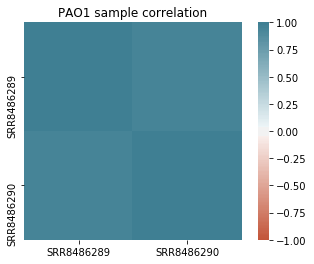

In [14]:
ax = sns.heatmap(
    pao1_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title("PAO1 sample correlation")

Text(0.5, 1.0, 'PA14 sample correlation')

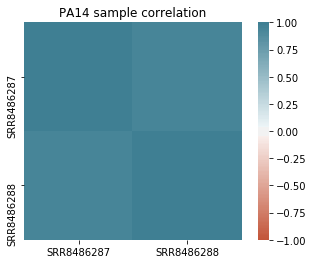

In [15]:
ax = sns.heatmap(
    pa14_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title("PA14 sample correlation")

In [16]:
# Get mean expression for pao1 and pa14
mean_pao1 = pao1_expression.mean()
mean_pa14 = pa14_expression.mean()

pao1_v_pa14_df = pd.DataFrame(data={'pao1_mean': mean_pao1.values,
                                   'pa14_mean': mean_pa14.values},
                             index=pao1_expression.columns)

pao1_v_pa14_df.head()

,pao1_mean,pa14_mean
PA3920,175.5,198.5
PA4207,2358.0,834.0
PA5232,2599.5,4118.0
PA3225,465.5,591.0
PA4211,32192.5,1171.0


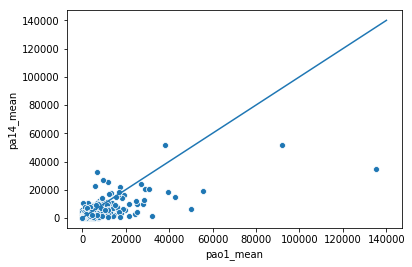

In [17]:
sns.scatterplot(data=pao1_v_pa14_df, x='pao1_mean', y='pa14_mean')
plt.plot([0,140000],[0,140000])

In [18]:
# Rough calculation of the number of genes that differ
# Here we are counting the genes with an expression difference between PAO1 and PA14 
# that is more than one standard deviation away from the overall mean of expression differences across genes

std_x_eq_y = np.std(abs(pao1_v_pa14_df['pao1_mean']-pao1_v_pa14_df['pa14_mean']))
gene_differences = pao1_v_pa14_df[abs(pao1_v_pa14_df['pao1_mean']-pao1_v_pa14_df['pa14_mean']) > std_x_eq_y]
print(gene_differences.shape)
genes_found_from_GE = list(gene_differences.index)
gene_differences.head()

(217, 2)


,pao1_mean,pa14_mean
PA4211,32192.5,1171.0
PA2445,8917.0,5732.0
PA4266,17768.0,5414.0
PA3257,7930.0,2717.5
PA1249,19942.0,6026.5


**Observations:**
* Looks like there is consistent gene expression patterns within sample-type (i.e. Both PAO1 samples have a similar gene expression profile, similarly for both PA14 samples) as expected
* Comparing the mean expression of PAO1 and PA14 we see that there are ~200 genes changed. This gives us some indication about what to expect for our DESeq analysis. However, we shouldn't expect the numbers to align because we are using different methods -- above we are comparing the raw gene expression values and looking for a threshold difference; below we DESeq fits the negative binomial model to the data and performs hypothesis testing to determine if there is a difference between the groups of samples.  

### Differential expression analysis

In [19]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2")

NULL


In [20]:
%%R
# Load the DESeq2 library
suppressPackageStartupMessages(library("DESeq2"))

In [21]:
# Files to load into DE analysis (R)
metadata_file = str(paths.SAMPLE_ANNOT_TEST)
expression_data_file = str(paths.PAO1_GE_DE)
out_file = str(paths.DE_STATS)

In [22]:
# Check ordering of sample ids
utils.check_sample_ordering(expression_data_file, metadata_file)

sample ids don't match, going to re-order gene expression samples


In [23]:
%%R -i metadata_file -i expression_data_file -i out_file

source('../core_acc_modules/DE_analysis.R')

get_DE_stats_DESeq(metadata_file,
                   expression_data_file,
                   out_file)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init_

[1] "Checking sample ordering..."
[1] TRUE


In [24]:
# Read in DE stats file
DE_stats = pd.read_csv(paths.DE_STATS, sep='\t', header=0, index_col=0)
print(DE_stats.shape)
DE_stats.head()

(5363, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PA3920,188.091908,-0.457365,0.307815,-1.485842,1.373209e-01,2.755381e-01
PA4207,1517.935973,1.228020,0.295656,4.153539,3.273719e-05,2.718790e-04
PA5232,3446.057140,-0.956034,0.243941,-3.919120,8.887297e-05,6.543490e-04
PA3225,536.163199,-0.637600,0.261391,-2.439260,1.471738e-02,4.808675e-02
PA4211,15153.334608,4.495239,0.240108,18.721745,3.291868e-78,3.461070e-75


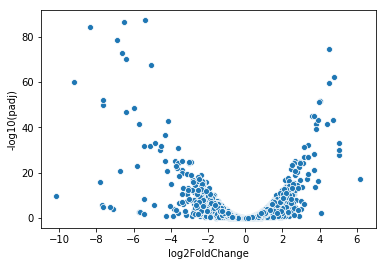

In [25]:
# Volcano plot
DE_stats["-log10(padj)"] = -np.log10(DE_stats["padj"])
sns.scatterplot(data=DE_stats, x="log2FoldChange", y="-log10(padj)")

### Compare our DE results with publication

In [26]:
# Get number of DEGs
selected_DE_stats = DE_stats[(DE_stats['padj']<0.01)]

print(selected_DE_stats.shape)
selected_DE_stats.head()

(1170, 7)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10(padj)
PA4207,1517.935973,1.228020,0.295656,4.153539,3.273719e-05,2.718790e-04,3.565624
PA5232,3446.057140,-0.956034,0.243941,-3.919120,8.887297e-05,6.543490e-04,3.184191
PA4211,15153.334608,4.495239,0.240108,18.721745,3.291868e-78,3.461070e-75,74.460790
PA4708,89.798831,-1.142241,0.356636,-3.202821,1.360886e-03,6.593714e-03,2.180870
PA3244,1494.417103,0.912364,0.248745,3.667869,2.445806e-04,1.547244e-03,2.810441


In [27]:
# Compare our findings against Sana et. al.
degs_sana = ["PA3431", "PA3432", "PA1244", "PA4685"]
for gene in degs_sana:
    if gene in list(selected_DE_stats.index):
        print(gene)

PA3431
PA3432
PA1244
PA4685


In [28]:
# Compare genes whose mean gene expression differed between PAO1 and PA14
# with those genes found using DESeq
top_degs_by_padj = selected_DE_stats.index
len(set(top_degs_by_padj).intersection(genes_found_from_GE))/len(genes_found_from_GE)

0.7373271889400922

**Conclusions:**

Our DE analysis found ~1.1K significantly differentially expressed genes

(Check 1): The DEGs identified using DESeq (\~1.1K genes) is fairly consistent with the genes that were 1 standard deviation outside the correlation threshold (\~200 genes) -- there was a 75% overlap in these gene sets. This very roughly validates that DESeq is working as expected. I wouldn't expect the numbers to be this different though.

(Check 2) The number of DEGs identified (\~1.1K genes) using DESeq is fairly consistent with the number of differentially expressed genes found in [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) (\~2K genes). We also spot checked specific genes that were found. We found the 4 genes highlighted in the Sana et. al. publication, including the main qsIA gene (PA1244) that the paper found to be more highly expressed in PAO1 vs PA14. Difference are likely due to differences in the package used. 

Approach used in [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) found ~ 2K DEGs between 2 strains where QS genes were DEGs:
```
Illumina reads were mapped to the P. aeruginosa genome PAO1 (GenBank accession number AE004091.2 [61]) and PA14 (GenBank accession number NC_008463.1 [33]) by Bowtie (version Bowtie1 v0.12.9 [62]). Data were normalized by reads per kilobase per million (RPKM) and filtered to the 5,263 orthologous genes conserved between P. aeruginosa strains PA14 and PAO1. Two biological replicates were performed per condition. Differential
expression analysis was analyzed using the Bioconductor package NOISeq version 2.22.1 (64), a nonparametric approach suitable for lowly replicated data, and using a q value of 0.99 for strong control of
false positives
```